In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import esm
from esm.data import ESMStructuralSplitDataset
import matplotlib.pyplot as plt

In [2]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

In [3]:
model.load_state_dict(torch.load('model_weights_1024_BCE.pth'))
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [4]:
model = torch.load('trained_model_1024_BCE_6ep.pth')
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [5]:
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [6]:
batch_converter = alphabet.get_batch_converter()
contact_threshold = 15

Data point 2805, KRVIPETFKTKVVVSRKELRESLKRVMVIASKGSESVKFEIEENVMRLVSKSPDYGEVVDEVEVQKEGEDLVIAFNPKFIEDVLKHIETEEIEMNFVDSTSPCQINPLDISGYLYIVMPIRLA


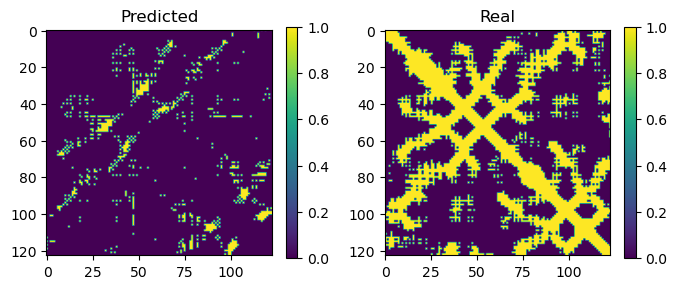

In [7]:
rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

# rand_example = np.random.randint(len(train_dataset))
# rand_target = train_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [26]:
# Load the example fastas to compare with repo results

from Bio import SeqIO
import os

def load_fasta_files(folder_path):
    
    fasta_files = [file for file in os.listdir(folder_path) if file.endswith(".fasta")]
    all_fasta_data = {}

    for fasta_file in fasta_files:
        file_path = os.path.join(folder_path, fasta_file)
        with open(file_path, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                all_fasta_data[record.id] = str(record.seq)

    return all_fasta_data

folder_path = r"C:\Users\neil_\Documents\GitHub\contact-prediction\data\Original"
fasta_data_dict = load_fasta_files(folder_path)

fasta_data_dict 

{'1A3A_1|Chains': 'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK',
 '1XCR_1|Chains': 'GSACAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD',
 '5AHW_1|Chains': 'MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS'}

In [27]:
fasta_data_dict["1A3A_1|Chains"]

'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'

In [28]:
sequences_list = [sequence for sequence in fasta_data_dict.values()]

In [29]:
sequences_list[0]

'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'

In [30]:
indexed_sequences = list(enumerate(sequences_list))

In [31]:
indexed_sequences

[(0,
  'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'),
 (1,
  'GSACAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD'),
 (2,
  'MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS')]

Data point 2, MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS


Text(0.5, 1.0, 'Prediction')

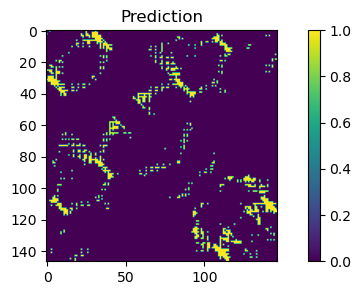

In [47]:
rand_example = np.random.randint(len(indexed_sequences))
rand_target = indexed_sequences[rand_example][1]

print(f"Data point {rand_example}, {rand_target}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target)])

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(figsize=(8, 3))
im = ax.imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax.set_title("Prediction")

In [8]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

In [9]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

In [18]:
# Load the PDB files for each example and calculate distances as the targets

def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 15.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

In [19]:
# precision and prediction evaluation

def compute_precisions(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(outputs, np.ndarray):
        outputs = torch.from_numpy(outputs)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if outputs.dim() == 2:
        outputs = outputs.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if outputs.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {outputs.size()}, "
            f"targets of size {targets.size()}"
        )
    device = outputs.device

    batch_size, seqlen, _ = outputs.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    
    # Check what the batch size is, comes from "batch_size, seqlen, _ = outputs.size()"
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long) 

    # check the masked_fill function in repo
    outputs = outputs.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = outputs[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(outputs).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [20]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

In [25]:
# This is where the data is actually read in

PDB_IDS = ["1a3a", "1xcr", "5ahw"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

# Downloaded fasta files directly from the PDB and saved in "data/" folder
sequences = {
    name: read_sequence(f"data/Original/{name.lower()}.fasta")
    for name in PDB_IDS
}

In [26]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(model.parameters()).device)
    esm2_predictions[name] = model.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

ValueError: Size mismatch. Received predictions of size torch.Size([1, 148, 148]), targets of size torch.Size([1, 145, 145])

IndexError: Inconsistent shape between the condition and the input (got (145, 145) and (148, 148))

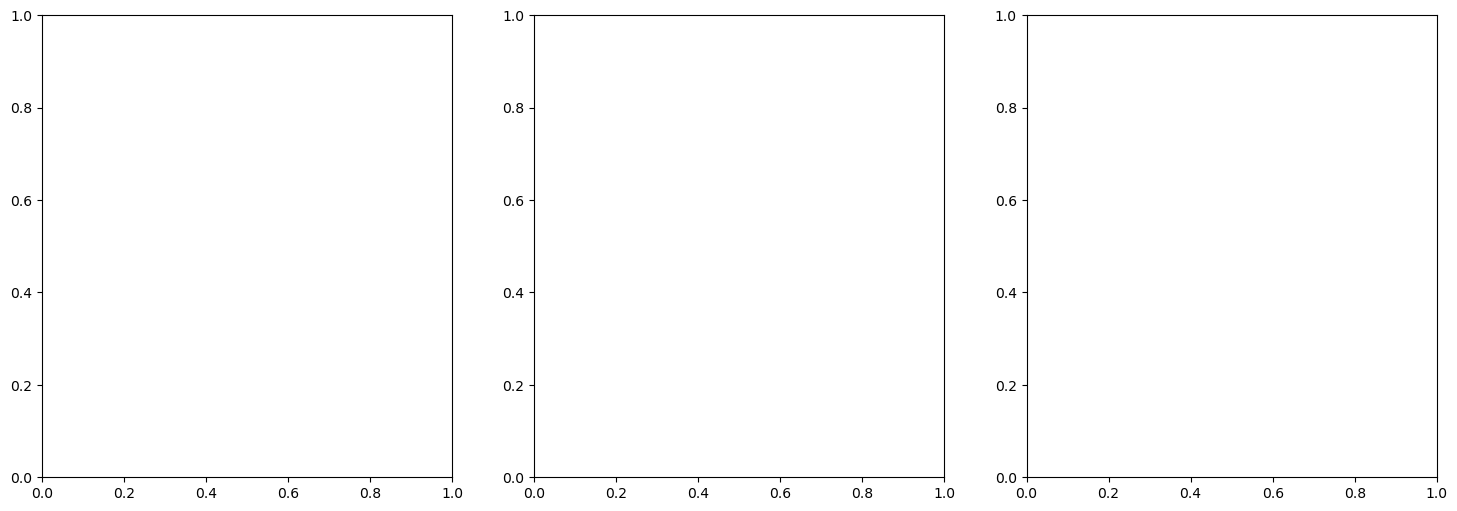

In [15]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [17]:
# Create benchmark details on contacts ROC AUC accuracy loss, P@L
outputs_met = torch.tensor(np.array(esm2_predictions[name]))
targets_met = torch.tensor(np.array(contacts[name]))

example_metrics = evaluate_prediction(outputs_met, targets_met)

print(f"Metrics for: {esm2_predictions[name]}") #, {rand_target}")
for key, value in example_metrics.items():
    print(f"{key}: {value}")  
del outputs_met, targets_met

ValueError: Size mismatch. Received predictions of size torch.Size([1, 148, 148]), targets of size torch.Size([1, 145, 145])